# Tests

### Imports

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import itertools

from scipy.spatial import cKDTree
from scipy         import sparse
from scipy.sparse  import linalg as sparse_linalg
from scipy.interpolate import interp1d
from numba         import njit

In [2]:
dimension = 1
npoints   = 200
nquads    = 1

r_in   = 1.0E13   # [m]
r_out  = 7.8E16   # [m]
nH2_in = 2.0E13   # [m^-3]
temp   = 2.0E+01  # [K]
turb   = 1.5E+02  # [m/s]

rs = np.logspace (np.log10(r_in), np.log10(r_out), npoints, endpoint=True)

X_mol = 1.0E-8

def nH2 (r):
    return nH2_in * np.power(r_in/r, 2.0)

def nTT (r):
    return X_mol  * nH2(r)

In [3]:
Nb = 10
Nd = 10
Nt = npoints

In [4]:
r_in  =  1.0
r_out =  5.0

xs = rs[::20]
xt = rs
ys = nTT(xs)
yt = nTT(xt)

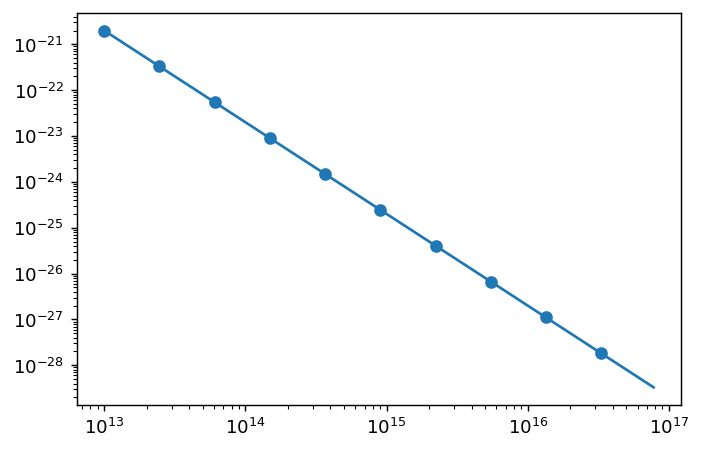

In [5]:
plt.figure(dpi=130)
plt.scatter(xs, ys)
plt.plot   (xt, yt)
plt.xscale('log')
plt.yscale('log')

In [108]:
hh = interp1d(0.5*(rs[:-1]+rs[1:]), 1.0*np.diff(rs),fill_value='extrapolate')

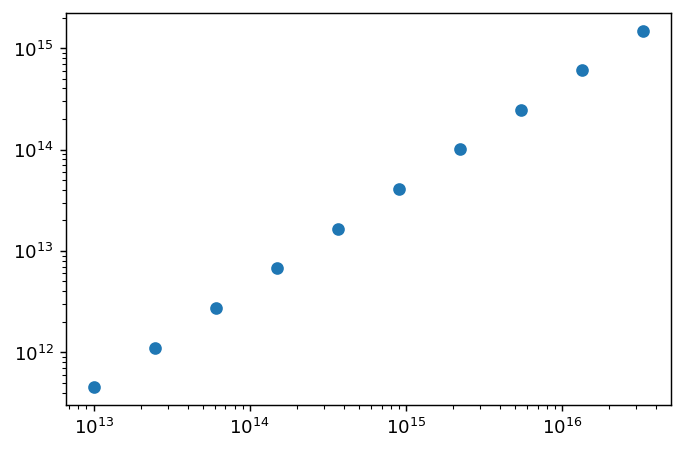

In [109]:
plt.figure(dpi=130)
plt.scatter(xs, hh(xs))
plt.xscale('log')
plt.yscale('log')

In [110]:
def RBF_Lucy(r):
    """
    Lucy's smoothing kernel (Lucy 1977).
    """
    if isinstance(r, np.ndarray):
        # Ensure to take the absolute value
        rr = np.abs(r)
        # Compute Lucy's kernel
        result          = (1.0 + 3.0*rr) * (1 - rr)**3
        result[rr>=1.0] = 0.0
        return result
    else:
        # Ensure to take the absolute value
        rr = np.abs(r)
        # Compute Lucy's kernel
        if (rr < 1.0):
            return (1.0 + 3.0*rr) * (1 - rr)**3
        else:
            return 0.0

In [111]:
def rbf(r):
    return np.exp(-0.5*r**2)

def rbf(r):
#     print(r)
    return RBF_Lucy(r)

In [112]:
# Define Gaussian (RBF) feature map
Phi = np.zeros((Nd, Nb))
for d in range(Nd):
    xd = xs[d]
    for i in range(Nb):
        xi = xs[i]
        rr = np.abs(xi - xd)
        Phi[d,i] = rbf(rr/hh(xi))

# Corresponding expansion
def f(x,w):
    result = np.zeros(x.shape)
    for i in range(Nb):
        xi = xs[i]
        rr = np.abs(xi - x)
        result += w[i]*rbf(0.1*rr/hh(xi))
    return result

In [112]:
NB = 1
NL = 5
Nd = NL + NB

# Define Gaussian (RBF) feature map
Phi = np.zeros((Nd, Nb))
for d in range(NL):
    xd = xs[d]
    for i in range(Nb):
        xi = xs[i]
        rr = np.abs(xi - xd)
        Phi[d,i] = rbf(rr/hh(xi))
for d in range(NL, Nd):

# Corresponding expansion
def f(x,w):
    result = np.zeros(x.shape)
    for i in range(Nb):
        xi = xs[i]
        rr = np.abs(xi - x)
        result += w[i]*rbf(0.1*rr/hh(xi))
    return result

In [113]:
Phi

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [114]:
K = np.matmul(Phi, Phi.T)
M = np.matmul(Phi.T, Phi)

In [115]:
print(np.linalg.det(M))
print(np.linalg.det(K))

1.0
1.0


In [116]:
# mat = np.matmul(K.T, K)
# w_K = np.matmul(np.linalg.solve(mat, ys).T, np.matmul(K.T, Phi))
mat = K
w_K = np.matmul(np.linalg.solve(mat, ys).T, Phi)
print(np.linalg.cond(mat), mat.shape)

1.0 (10, 10)


In [117]:
w_K

array([2.00000000e-21, 3.30140969e-22, 5.44965299e-23, 8.99576860e-24,
       1.48493588e-24, 2.45119086e-25, 4.04619264e-26, 6.67906980e-27,
       1.10251729e-27, 1.81993063e-28])

In [118]:
mat = M
w_M = np.linalg.solve(mat, np.matmul(Phi.T, ys))
print(np.linalg.cond(mat), mat.shape)

1.0 (10, 10)


In [119]:
w_M

array([2.00000000e-21, 3.30140969e-22, 5.44965299e-23, 8.99576860e-24,
       1.48493588e-24, 2.45119086e-25, 4.04619264e-26, 6.67906980e-27,
       1.10251729e-27, 1.81993063e-28])

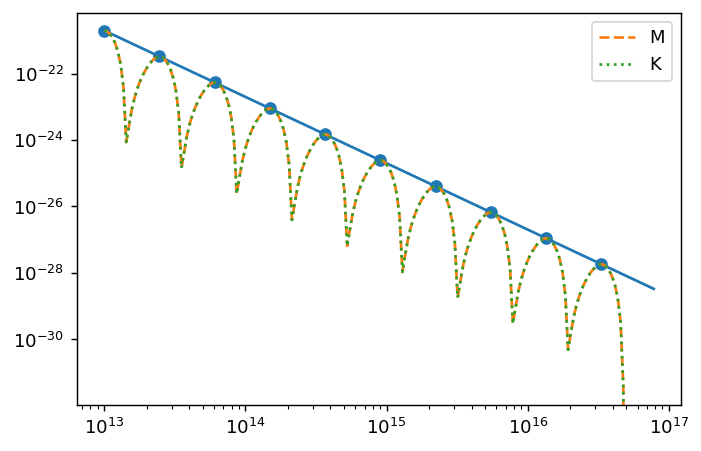

In [120]:
plt.figure(dpi=130)
plt.scatter(xs, ys)
plt.plot   (xt, yt)
plt.plot   (xt, f(xt, w_M), label='M', linestyle='dashed')
plt.plot   (xt, f(xt, w_K), label='K', linestyle='dotted')
# plt.plot   (xt, f(xt, np.identity(Nb)[2]))
plt.legend()

plt.xscale('log')
plt.yscale('log')

No handles with labels found to put in legend.


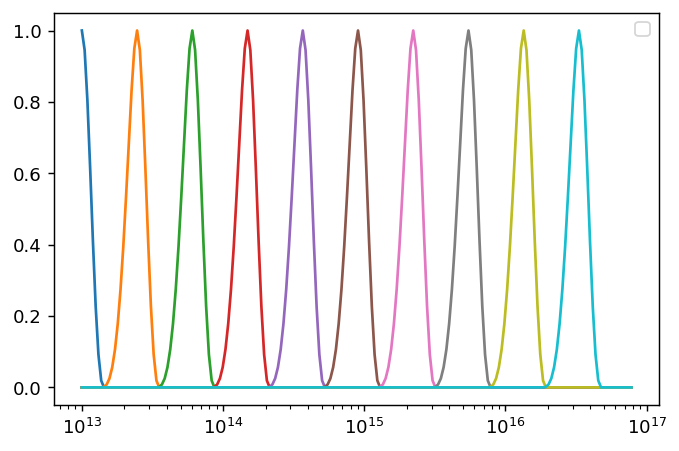

In [121]:
plt.figure(dpi=130)
# plt.scatter(xs, ys)
# plt.plot   (xt, yt)
# plt.plot   (xt, f(xt, w_M), label='M', linestyle='dashed')
# plt.plot   (xt, f(xt, w_K), label='K', linestyle='dotted')

for i in range(Nb):
    plt.plot(xt, f(xt, np.identity(Nb)[i]))

plt.legend()

plt.xscale('log')
# plt.yscale('log')

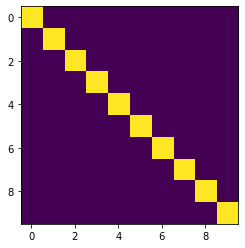

In [122]:
plt.imshow(K)

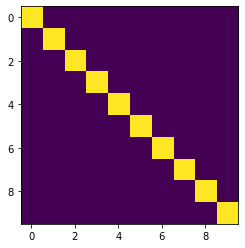

In [123]:
plt.imshow(M)